# pbpk-tutorial
## Whole-body physiological based pharmacokinetics model for caffeine
The model describes clearance of caffeine by the liver in Humans.

* Caffeine and the primary metabolite paraxanthine are removed from the blood stream by hepatic or renal clearance.
* Caffeine can be applied either as intra-venous injection or by oral dose in the model

This notebook demonstrates some simple use cases and analysis of the model.

* the ODE equations were generate directly from the SBML of the caffeine model
* initial values `X0`, parameter values `pars`, and the ODE system `dxdt` are defined in the `caffeine.py`

![Fig.1 Caffeine PKPD Model](figures/caffeine_pkpd.png)

This tutorial works in a minimal python environment with the following package
```
numpy
scipy
matplotlib
pandas
libroadrunner
```

The packages can be installed via
```
pip install numpy scipy matplotlib pandas libroadrunner
```
or in `conda` via
```
pip install numpy scipy matplotlib pandas libroadrunner
```

For questions contact konigmatt@googlemail.com. The latest version of the resources are available from https://github.com/matthiaskoenig/pkpd-tutorial with 

* [notebooks/caffeine.py](https://github.com/matthiaskoenig/pkpd-tutorial/blob/master/notebooks/caffeine.py) 
* [notebooks/pkpd-tutorial.ipynb](https://github.com/matthiaskoenig/pkpd-tutorial/blob/master/notebooks/pkpd-tutorial.ipynb)

In [1]:
# general imports for ode integration
import numpy as np
import pandas as pd
import roadrunner
from matplotlib import pylab as plt
import helpers
from pprint import pprint
from imp import reload
reload(helpers)
from helpers import *

# global settings for plots (optional)
plt.rcParams.update({
        'axes.labelsize': 'large', 
        'axes.labelweight': 'bold',
        'axes.titlesize': 'large',
        'axes.titleweight': 'bold',
        'legend.fontsize': 'small',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
    })

## Load the caffeine model
The full model report with information about the parameter names is available at


In [2]:
# load the model
r = roadrunner.RoadRunner(caffeine_model)
# set variables in result
r.timeCourseSelections = ["time"] + r.model.getFloatingSpeciesIds() + r.model.getGlobalParameterIds()
# pprint(r.timeCourseSelections)

## Example simulation
We now simulate a 100 [mg] oral dose (p.o) of caffeine. 
In a first step we perform this simulation and look at some state variables of the model.

The model time is in [h]. The simulation result is a pandas DataFrame which can easily be accessed.

In [7]:
# reset model to initial state
r.reset(roadrunner.SelectionRecord.ALL)

# set the oral dose
r['init(PODOSE_caf)'] = 100  # [mg]

# simulate the model for 24[h]
s = simulate(r, start=0, end=24, steps=500)

# show the resulting DataFrame
display(s.head())

,time,BW,CO,FVre,FVgu,FVki,FVli,FVlu,FVsp,FVve,...,Cli_free_px,Cki_free_px,CLliv_px,vliv_px,Absorption_caf,Venous_caf,Absorption_px,Venous_px,Abody_caf,Abody_px
0,0.000,70.0,108.33,0.9049,0.0171,0.0044,0.021,0.0076,0.0026,0.0514,...,0.000000,0.000000,11.907,0.000000,250.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.048,70.0,108.33,0.9049,0.0171,0.0044,0.021,0.0076,0.0026,0.0514,...,0.119169,0.012902,11.907,1.418946,221.730109,195.237839,0.0,11.283537,10.936949,0.345689
2,0.096,70.0,108.33,0.9049,0.0171,0.0044,0.021,0.0076,0.0026,0.0514,...,0.236954,0.053722,11.907,2.821412,196.656965,325.289528,0.0,26.719440,20.042439,1.163572
3,0.144,70.0,108.33,0.9049,0.0171,0.0044,0.021,0.0076,0.0026,0.0514,...,0.290249,0.086389,11.907,3.455996,174.419082,399.057352,0.0,37.908947,27.878691,2.069801
4,0.192,70.0,108.33,0.9049,0.0171,0.0044,0.021,0.0076,0.0026,0.0514,...,0.315503,0.111110,11.907,3.756691,154.695848,452.052947,0.0,46.762611,34.701221,2.962668


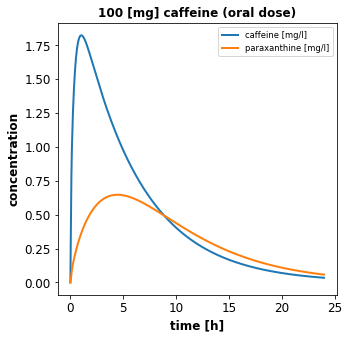

In [8]:
# plot venous caffeine & paraxanthine against time
f1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
ax1.plot(s.time, s.Cve_caf, linewidth=2, label="caffeine [mg/l]")
ax1.plot(s.time, s.Cve_px, linewidth=2, label="paraxanthine [mg/l]")
ax1.set_title('100 [mg] caffeine (oral dose)')
ax1.set_ylabel('concentration')
ax1.set_xlabel('time [h]')
ax1.legend()
plt.show()

## Compare amounts in different organs
In the following we compare the amount of caffeine in the different organs.
For this we select all the columns in the solution which belong the amount of caffeine.

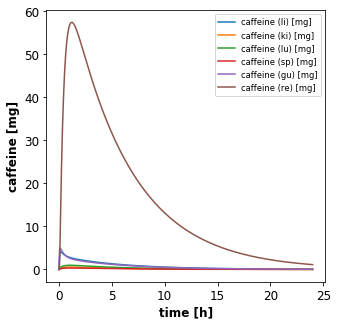

In [9]:
# plot caffeine and paraxanthine amounts
f1, ax1 = plt.subplots(1, 1, figsize=(5,5))
organs = ["li", "ki", "lu", "sp", "gu", "re"]

for organ in organs:
    sid = "A{}_caf".format(organ)
    label = "caffeine ({}) [mg]".format(organ)
    ax1.plot(s.time, s[sid], label=label)    

ax1.set_ylabel('caffeine [mg]')
ax1.set_xlabel('time [h]')
ax1.legend()

plt.show()

## Plot the organ volumes
In the following we plot the organ volumes by querying the model

In [10]:
for oid in organs:
    vid = "V{}".format(oid)
    print("V{} = {} [l]".format(oid, r[vid]))

Vli = 1.47 [l]
Vki = 0.308 [l]
Vlu = 0.532 [l]
Vsp = 0.182 [l]
Vgu = 1.197 [l]
Vre = 63.343 [l]


## Stepwise increase of the caffeine dose
Now we see what happens if we drink more coffee every day

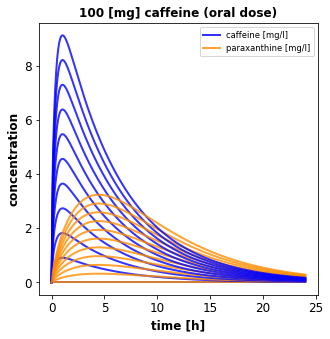

In [11]:
doses = np.linspace(0, 500, num=11)
results = []

for dose in doses:
    # reset model to initial state
    r.reset(roadrunner.SelectionRecord.ALL)
    
    # set the oral dose
    r['init(PODOSE_caf)'] = dose  # [mg]

    # simulate the model for 24[h]
    s = simulate(r, start=0, end=24, steps=500)
    results.append(s)

# plot venous caffeine & paraxanthine against time
f1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
for k, s in enumerate(results):
    if k == 1:
        label = "caffeine [mg/l]"
    else:
        label = "__nolabel__"
    ax1.plot(s.time, s.Cve_caf, linewidth=2, color="blue", label=label, alpha=0.8)
    if k == 1:
        label = "paraxanthine [mg/l]"
    else:
        label = "__nolabel__"
    ax1.plot(s.time, s.Cve_px, linewidth=2, color="darkorange", label=label, alpha=0.8)
ax1.set_title('100 [mg] caffeine (oral dose)')
ax1.set_ylabel('concentration')
ax1.set_xlabel('time [h]')
ax1.legend()
plt.show()


# Exercises
## E1 Your caffeine level
The first exercise is to calculate the timecourse of the expected venous caffeine level after you drink some caffeinated beverage. To estimate your oral dose of caffeine you can estimate the caffeine content from the following chart

![Fig.2 Caffeine Content of Beverages](figures/caffeine_levels.jpg)

The oral dose is defined in the model via parameter `r['init(PODOSE_caf)'] = 100` [mg]. In addition you can also adjust the bodyweight to get a more realistic estimation via the parameter `p[0] = 70` [kg].

* What would be your level of caffeine now, if you had two cups of coffee for breakfast this morning?
* How would your time course and level of caffeine look if you would take the same amount of caffeine intravenously (I.V)? (Hint: you have to set the set the i.v. dose via `r['init(IVDOSE_caf)'] = 100`)
* What is the peak time of caffeine in venous blood? What is the peak concentration?

## E2 Interindividual variability
We saw that there is a large variability in caffeine kinetics in the population. Depending on if you are a fast or slow metabolizer of caffeine the timecourses can look very different. In E1 you calculated the mean timecourse for the population. Now we will look at the interindividual differences.

Your caffeine clearance by the liver depends on the activity of CYP1A2 in the liver, the main enzyme metabolizing caffeine. The activity is defined via the apparent clearance caffeine by hepatic microsomes `p[43] = 2` [mul/min/mg].

* How would your time course / level of caffeine change if you are a slow metabolizer (small apparent clearance), or if you are a fast metabolizer (large apperent clearance)?
* Simulate the effect of lifestyle changes on your caffeine clearance via adjusting the caffeine clearance accordinly. For instance simulate changes in your coffee intake or smoking habit. An overview over the changes in apparent clearance are given in Tab.1. 
* How would your caffeine timecourse change if you smoke >20 cigarettes per day and drink 1 liter of coffee (the effects are additive) compared to being abstinent?
* Also the bodyweight has a strong influence on the distribution of caffeine. What happens when setting your body weight? (`r.BW = 75` [kg]) 

![Tab.1 Lifestyle Effects](figures/Tantcheva-Poor1999_Tab4.png)

## E3 Repeated dosing

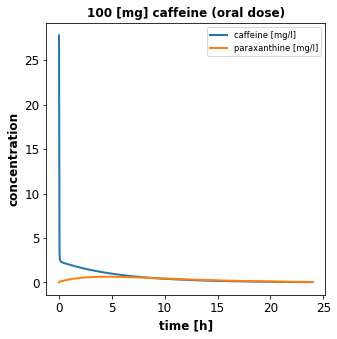

In [12]:
# reset model to initial state
r.reset(roadrunner.SelectionRecord.ALL)

# set the oral dose
# r['init(PODOSE_caf)'] = 100
r['init(IVDOSE_caf)'] = 100  # [mg]

# simulate the model for 24[h]
s = simulate(r, start=0, end=24, steps=500)

# show the resulting DataFrame

# plot venous caffeine & paraxanthine against time
f1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
ax1.plot(s.time, s.Cve_caf, linewidth=2, label="caffeine [mg/l]")
ax1.plot(s.time, s.Cve_px, linewidth=2, label="paraxanthine [mg/l]")
ax1.set_title('100 [mg] caffeine (oral dose)')
ax1.set_ylabel('concentration')
ax1.set_xlabel('time [h]')
ax1.legend()
plt.show()